In [73]:
# Sentiment Analysis - Amazon Reviews
# Tutorial by Rob Mulla
# VADER (Valence Aware Dictionary and sEntiment Reasoner): BoW Approach
# Transformer HuggingFace Pretrained Roberta Model
# Hugging Face Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
nltk.download('words')

print("NLTK version:", nltk.__version__)
# print(nltk.data.path)

NLTK version: 3.8.1


[nltk_data] Downloading package words to
[nltk_data]     /Users/aidanschmelzle/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [74]:
plt.style.use('ggplot')
df = pd.read_csv('./Reviews.csv') # Read in the data

In [75]:
print(df.head(), "\n") # print the head of the dataset 
print(df['Text'].values[0], "\n")
print(df.shape, "\n") # result: (568454, 10) 

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [76]:
# Downsample the size of the dataset for time's sake:
df = df.head(500)
print(df.shape, "\n") # result: (500, 10) 

(500, 10) 



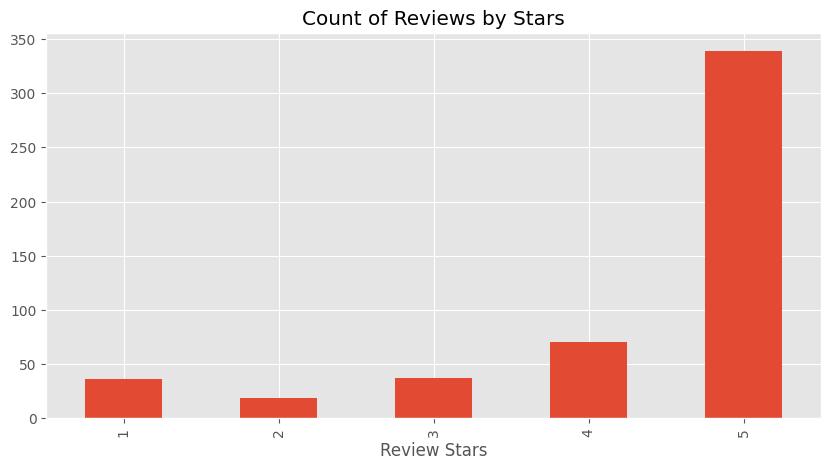

In [77]:
# Preliminary EDA (Exploratory Data Analysis):
axis = df['Score'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Count of Reviews by Stars', 
          figsize=(10,5))
axis.set_xlabel('Review Stars')
plt.show()

In [78]:
# Moving on to some basic NLTK:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [79]:
tokens = nltk.word_tokenize(example,language='english', preserve_line=True)
print(tokens[:10])

['This', 'oatmeal', 'is', 'not', 'good.', 'Its', 'mushy', ',', 'soft', ',']


In [80]:
# find the part of speech for each word:
tagged = nltk.pos_tag(tokens, lang="eng") # part-of-speech tagging
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good.', 'VB'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ',')]

In [81]:
entities = nltk.chunk.ne_chunk(tagged) # takes the recommended name-entity chunker to chunk the given list of tagged tokens (groups tokens into chunks of text)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good./VB
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it./JJ
  (PERSON Quaker/NNP Oats/NNP)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


Step 2. VADER Sentiment Scoring
Using NLTK's SentimentIntensityAnalyzier to get the neg/neu/pos scores of the text.

This uses a "Bag of Words" Approach:
1. Stop words are removed
2. each word is scored and combined to a total score

Takes all the words in the sentence and has a positive, negative, or neutral value for each words, and it combines sentiments to tell you the overall value of the statement based on all the words. Does not account for relationships between words (very important in human speech), but it is a good start. Removes stop words (and, the, etc).

In [82]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aidanschmelzle/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [83]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm # progress bar tracker for data loops 

sia = SentimentIntensityAnalyzer()


In [84]:
sia # <nltk.sentiment.vader.SentimentIntensityAnalyzer at 0x132b24f50>

In [85]:
sia.polarity_scores("I am so happy!") # {'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [86]:
sia.polarity_scores("This is the worst thing ever.") # {'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [87]:
sia.polarity_scores(example) # {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}
# recall: example = "This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [88]:
# run the polarity score on the entire dataset
res = {} # dictionary to store results
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myID = row['Id']
    res[myID] = sia.polarity_scores(text) # every time we loop through, we will take myID and store in "myID" part of the dictionary the polarity score of the text

  0%|          | 0/500 [00:00<?, ?it/s]

In [89]:
vaders = pd.DataFrame(res).T # ".T" will flip everything horizontally
vaders = vaders.reset_index().rename(columns={'index': 'Id'}) # reset the index and rename the index as our ID so we can merge onto original dataframe
vaders = vaders.merge(df, how='left') # left merge onto original dataframe

In [90]:
vaders.head() # now we have sentiment score and metadata

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Plot VADER results

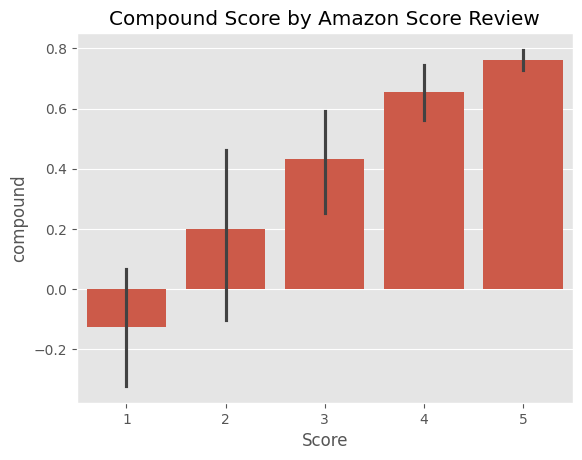

In [91]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title("Compound Score by Amazon Score Review")
plt.show()

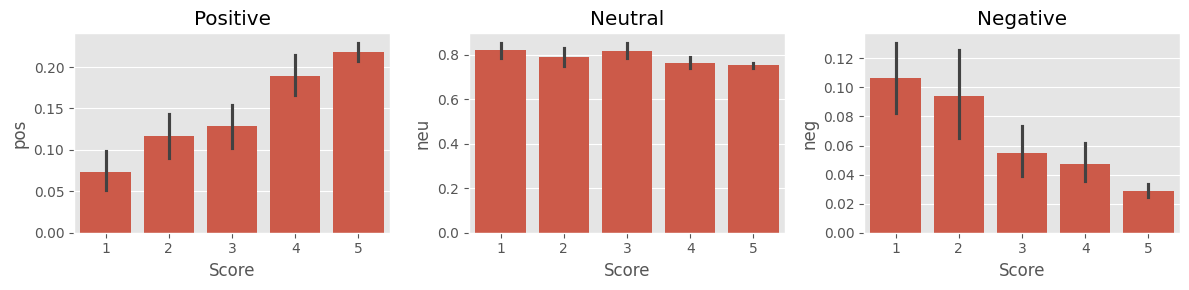

In [92]:
# let's take a look at the positive, negative, and neutral scores for each:
fix, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0]) # more positive of a comment as the star review increases
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1]) # flat
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2]) # becomes less negative of a comment as the star review is higher - confirms what we would hope to see as far as the correlation from star score and sentiment score
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Step 3. Roberta Pretrained Model
1. Use a model trained on a large corpus of data
2. Transformer model accounts for the words but also the context related to other words

Human language depends a lot on context (negative words may be sarcastic or related to other words), so a sentence with positive sentiment may be misclassified as negative. VADER would not pick up on this sort of relationship, but these transformer based deep-learning models can pick up on that context.

We will use ROBERTA from Hugging Face.

In [93]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [94]:
# pull in a model that has been pre-trained on a bunch of sentiment data:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment" # provided by Hugging Face
tokenizer = AutoTokenizer.from_pretrained(MODEL) # when we run the autotokenizer and the ....
model = AutoModelForSequenceClassification.from_pretrained(MODEL) # automodel seq classification methods and load from a pre-trained model, it will pull down the model weights that have been stored

In [95]:
# VADER Results on example
print(example) # This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
sia.polarity_scores(example) # {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}


This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [96]:
# Now we want to run this on the ROBERTA model
encoded_text = tokenizer(example, return_tensors='pt') # first encode the text. Apply tokenizer we have pulled in to the example
# encoded text -> takes that text and puts it into embeddings (1's and 0's) that the model can understand
output = model(**encoded_text)
# output # SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None) - TENSOR OF RESULTS
scores = output[0][0].detach().numpy() # take it from being a tensor and make it into numpy so we can store it locally (detach)
scores = softmax(scores)
# scores # array([0.97635514, 0.02068746, 0.00295737], dtype=float32) - SHOWS NEG, NEU, AND POS FOR THIS TEXT
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict) # {'roberta_neg': np.float32(0.97635514), 'roberta_neu': np.float32(0.020687463), 'roberta_pos': np.float32(0.0029573694)}
# ROBERTA believes much more strongly that this is a negative sentiment as compared to the VADER model

{'roberta_neg': np.float32(0.97635514), 'roberta_neu': np.float32(0.020687463), 'roberta_pos': np.float32(0.0029573694)}


In [97]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [98]:
res = {} # dictionary to store results
for i, row in tqdm(df.iterrows(), total=len(df)):
    try: # running without the try/except errors due to the size of the text
        text = row['Text']
        myID = row['Id']
        vader_result = sia.polarity_scores(text) # bc we will still run our VADER text on this
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result} # we want to combine these
        res[myID] = both
    except RuntimeError: # runs except for when the RTE occurs
        print(f'Broke for id {myID}') # RuntimeError: The expanded size of the tensor (571) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 571].  Tensor sizes: [1, 514]
# slow as running only on CPU -> these transformer models are optimized to run on a GPU        

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [99]:
results_df = pd.DataFrame(res).T # ".T" will flip everything horizontally
results_df = results_df.reset_index().rename(columns={'index': 'Id'}) # reset the index and rename the index as our ID so we can merge onto original dataframe
results_df = results_df.merge(df, how='left') # left merge onto original dataframe

In [100]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098068,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [101]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

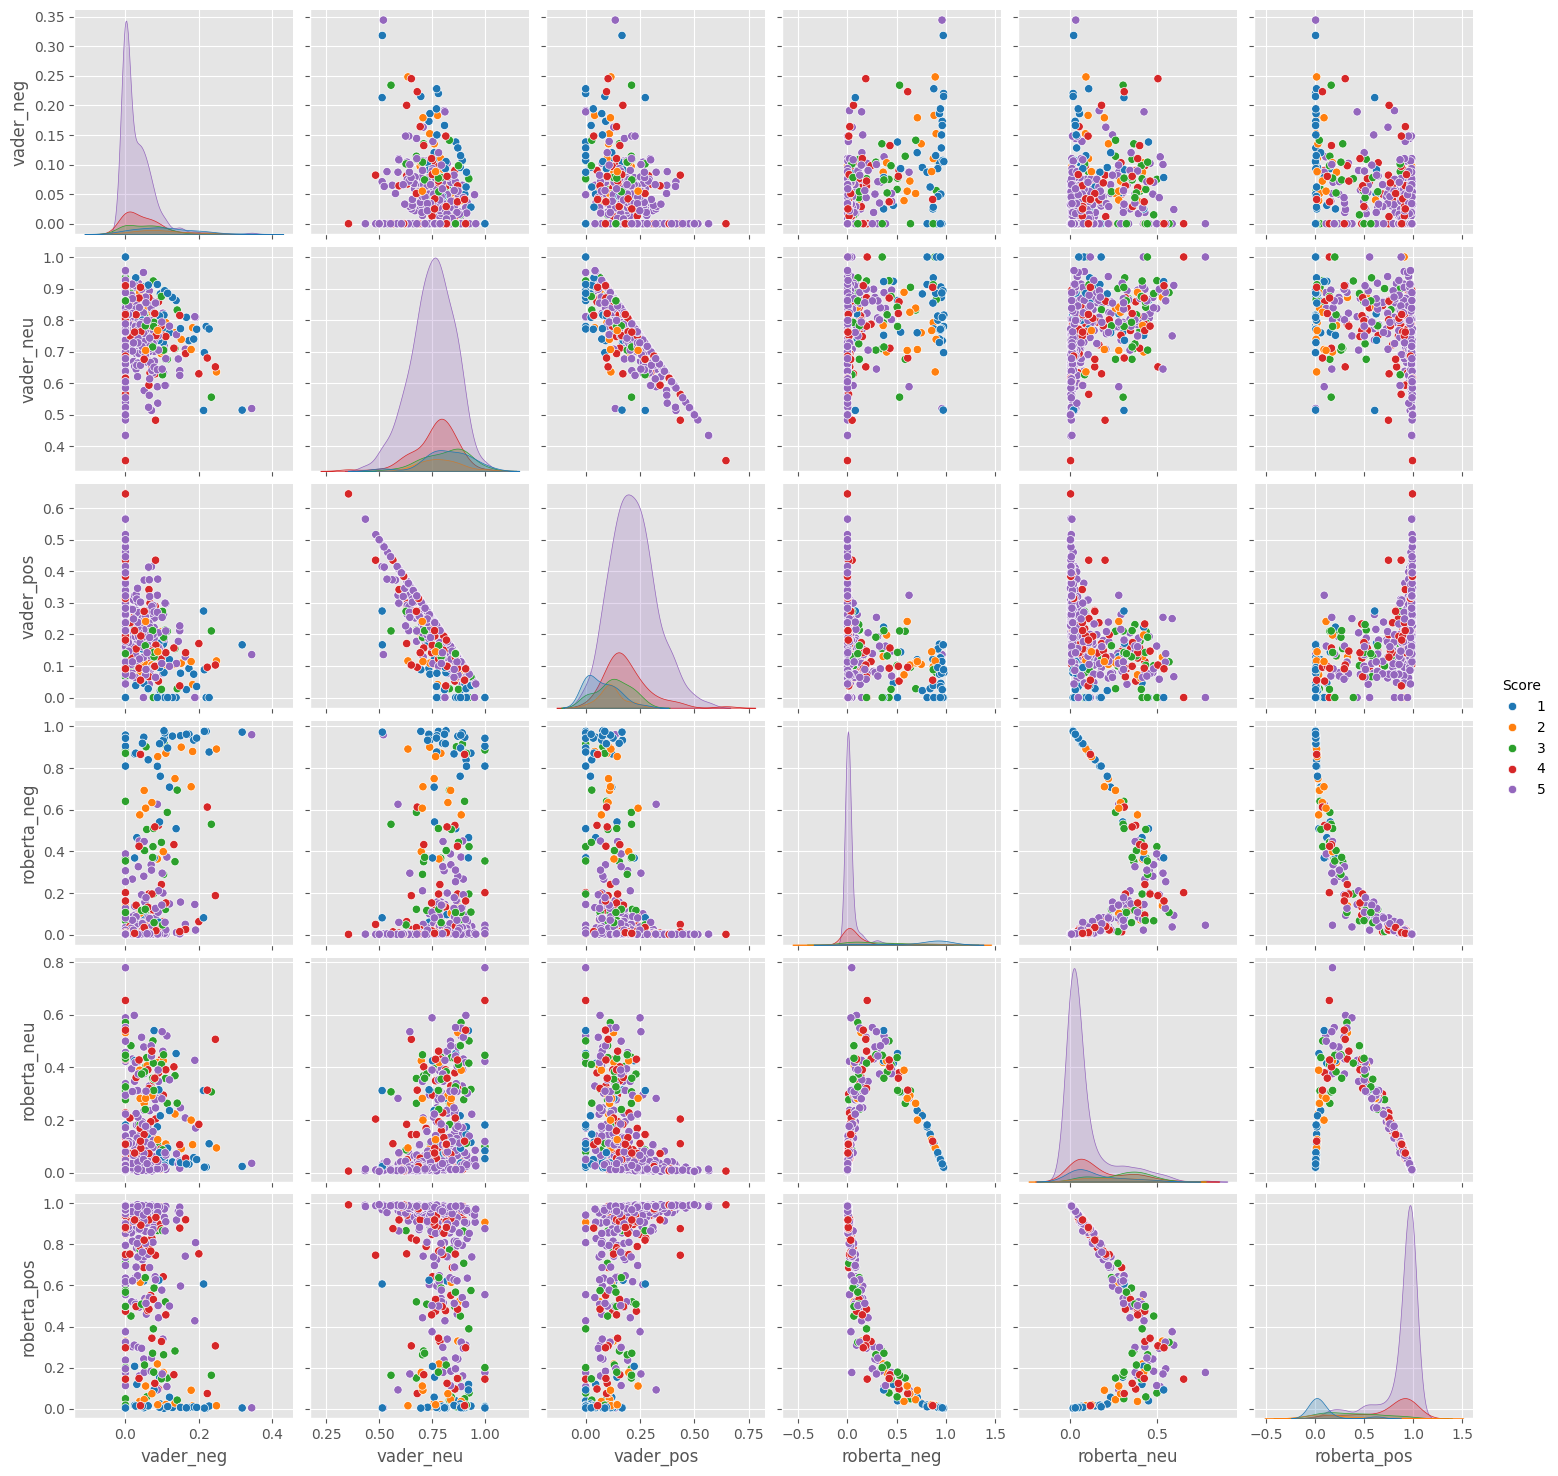

In [102]:
# compare scores between models using seaborn's pair plot
sns.pairplot(data=results_df, 
             vars=['vader_neg', 'vader_neu', 'vader_pos', 
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

Step 4: Review Examples
1. Positive 1-Star and Negative 5-Star Reviews
Let's look at some examples where the model scoring and review score differ the most.
- Now that we have sentiment score and we know the 5-Star ranking of the review, we can see the model do the opposite of what we think it should

In [103]:
results_df.query('Score==1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0] # highest positivity score where the rating is 1 
    # i.e. text that is said to be positive by the model but is 1-star by what the actual reviewer said.
    # output = 'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [104]:
results_df.query('Score==1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0] # repeat for VADER
    # output = 'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [105]:
# negative sentiment 5-star review
results_df.query('Score==5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]
# output = 'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [106]:
results_df.query('Score==5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]
# output = 'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault' - Same as Roberta

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

EXTRA: The Hugging Face Transformers Pipeline
- Quick and easy way to run sentiment predictions

In [107]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis") # tasks that it is automatically set up for
# we want to do sent analysis. this will automatically download their default model and embeddings for this pipeline and allows us to run sent analysis with just 2 lines of code.
# you can even change what model it uses and the different tokenizers

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [108]:
sent_pipeline('I love sentiment analysis!') # output: [{'label': 'POSITIVE', 'score': 0.9997853636741638}]

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [109]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [110]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [111]:
vader_result # {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}
roberta_result # {'roberta_neg': np.float32(0.009624217),
#  'roberta_neu': np.float32(0.049980365),
#  'roberta_pos': np.float32(0.94039536)}

{'roberta_neg': np.float32(0.0024397618),
 'roberta_neu': np.float32(0.011327231),
 'roberta_pos': np.float32(0.986233)}

In [112]:
both

{'vader_neg': 0.0,
 'vader_neu': 0.678,
 'vader_pos': 0.322,
 'vader_compound': 0.9811,
 'roberta_neg': np.float32(0.0024397618),
 'roberta_neu': np.float32(0.011327231),
 'roberta_pos': np.float32(0.986233)}